## Initial modeling experiments

In [51]:
# Setup
import os
import pandas as pd
import yaml
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings

from lazypredict.Supervised import LazyRegressor

# Connect to database (to update to environment variable later)
with open('database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

### 1. Read data

In [22]:
def read_labels(engine, keep='all'):
    '''
    args:
        - sql engine object
        - keep: either 'all' (all labeled points) or 
                'simple' (remove nonstandard cases where year is entered or card is handwritten)
    '''

    if keep == 'all':
        sql = 'SELECT * FROM samples.building_values WHERE building_value is not null'

    if keep == 'simple':
        sql = '''SELECT parcelid, building_value
                 FROM samples.building_values 
                 WHERE year is null and handwritten is null and building_value is not null'''

    return pd.read_sql(sql, engine)

def read_features(engine):
    sql = '''
            SELECT parcelid,
                    bi.attic_sqft, bi.bsmt_sqft, bi.live_sqft, bi.sqft_flr1, 
                    bi.sqft_flr2, bi.sqft_flrh, bi.story_ht, bi.year_built, bi.prop_class_code, bi.class_description,

                    hs.number_of_parcels, hs.date_of_sale, hs.appraisal_area, hs.total_sales_records, hs.sale_price,
                    hs.style, hs.grade, hs.exterior_wall_type, hs.basement, hs.heating, hs.air_conditioning, hs.total_rooms,
                    hs.full_bath, hs.half_bath, hs.fireplaces, hs.garage_type, hs.finished_sq_ft, hs.total_finish_area,
                    hs.first_floor_area, hs.half_floor_area, hs.finished_basement

            FROM processed.building_info bi JOIN processed.historic_sales hs USING(parcelid)
         '''
    
    return pd.read_sql(sql, engine)
                

def read_data(engine, keep='all'):
    labels = read_labels(engine, keep)
    features = read_features(engine)

    merged = pd.merge(labels, features, on='parcelid')

    if len(labels) != len(merged):
        warnings.warn(f"There are {len(labels) - len(merged)} labeled rows getting dropped when merging to feature data.") 
    
    if merged['prop_class_code'].isna().sum() > 0:
        warnings.warn(f"There is missing feature data for labels where there shouldn't be.")

    return merged


In [23]:
df = read_data(engine, keep='simple')
df.head()

,parcelid,building_value,attic_sqft,bsmt_sqft,live_sqft,sqft_flr1,sqft_flr2,sqft_flrh,story_ht,year_built,...,total_rooms,full_bath,half_bath,fireplaces,garage_type,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement
0,0590006004100,3140.0,420,954,2408,994,994,0,2.0,1895.0,...,10.0,3.0,0.0,0.0,Attached-Frame Construction,994.0,2408.0,994.0,994.0,0.0
1,1190001019100,4270.0,0,1184,1184,1184,0,0,1.0,1929.0,...,5.0,1.0,1.0,1.0,Detached-001-Frame Construction,1184.0,1184.0,1184.0,0.0,0.0
2,1790077012500,3250.0,424,908,1467,1043,0,0,1.0,1923.0,...,7.0,1.0,1.0,0.0,Detached-001-Frame Construction,1043.0,1467.0,1043.0,0.0,350.0
3,2430003008600,2720.0,372,776,1499,1127,0,0,1.0,1925.0,...,6.0,1.0,0.0,0.0,Detached-001-Frame Construction,1127.0,1499.0,1127.0,0.0,0.0
4,0380006005600,4910.0,0,1246,2266,1246,1020,0,2.0,1928.0,...,9.0,2.0,1.0,1.0,Basement Garage,1246.0,2266.0,1246.0,1020.0,276.0


In [35]:
# Some basic sanity checks
print(f"There are {len(df)} labeled observations")
print(df.columns)


There are 1753 labeled observations
Index(['parcelid', 'building_value', 'attic_sqft', 'bsmt_sqft', 'live_sqft',
       'sqft_flr1', 'sqft_flr2', 'sqft_flrh', 'story_ht', 'year_built',
       'prop_class_code', 'class_description', 'number_of_parcels',
       'date_of_sale', 'appraisal_area', 'total_sales_records', 'sale_price',
       'style', 'grade', 'exterior_wall_type', 'basement', 'heating',
       'air_conditioning', 'total_rooms', 'full_bath', 'half_bath',
       'fireplaces', 'garage_type', 'finished_sq_ft', 'total_finish_area',
       'first_floor_area', 'half_floor_area', 'finished_basement'],
      dtype='object')


### 2. Data exploration

In [25]:
# For variables that have missing values, what is the % missing?
null_perc = df.isna().mean()
null_perc = null_perc[null_perc > 0]
null_perc

number_of_parcels      0.000570
date_of_sale           0.000570
total_sales_records    0.000570
sale_price             0.127210
basement               0.003993
garage_type            0.485454
dtype: float64

Distribution of initial building value
count     1753.000000
mean      3532.549914
std       2756.879989
min        130.000000
25%       2270.000000
50%       3100.000000
75%       4060.000000
max      57700.000000
Name: building_value, dtype: float64


[Text(0.5, 1.0, 'Histogram of labeled building value')]

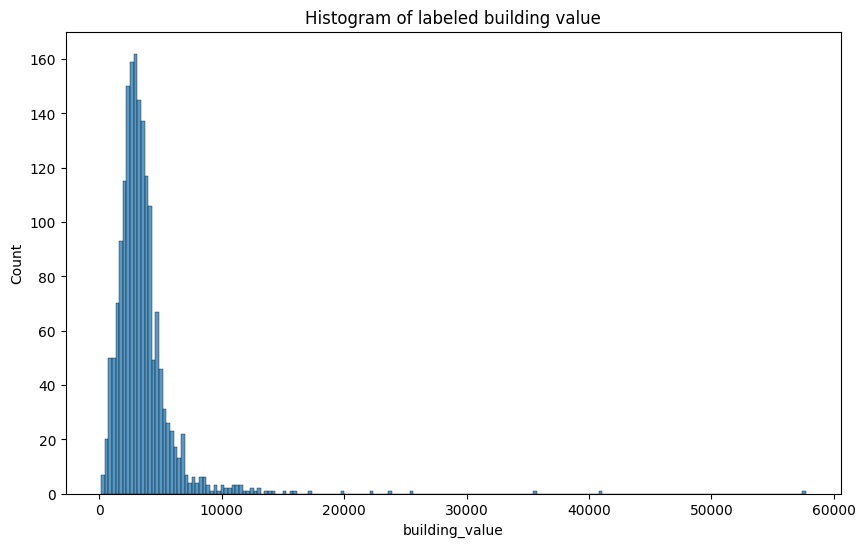

In [26]:
# Distribution of the outcome variable
print('Distribution of initial building value')
print(df['building_value'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df, x='building_value').set(title='Histogram of labeled building value')

In [29]:
## When were these properties built?
print('Distribution of build year')
print(df['year_built'].describe())

Distribution of build year
count    1753.000000
mean     1910.645750
std        15.961301
min      1847.000000
25%      1900.000000
50%      1915.000000
75%      1924.000000
max      1929.000000
Name: year_built, dtype: float64


In [30]:
## How large are these buildings?
print('Distribution of building size')
print(df['live_sqft'].describe())

Distribution of building size
count     1753.000000
mean      1789.252139
std        842.536017
min        504.000000
25%       1248.000000
50%       1609.000000
75%       2123.000000
max      10866.000000
Name: live_sqft, dtype: float64


In [31]:
## Correlations between the outcome and numeric variables
df.corrwith(df['building_value'], numeric_only=True).sort_values()

appraisal_area        -0.116525
total_sales_records   -0.024728
number_of_parcels     -0.017207
sqft_flrh              0.058089
prop_class_code        0.104430
story_ht               0.143004
finished_basement      0.171853
sale_price             0.231051
year_built             0.297453
half_bath              0.303908
attic_sqft             0.340150
finished_sq_ft         0.402297
full_bath              0.421464
fireplaces             0.433218
total_rooms            0.468342
half_floor_area        0.491032
sqft_flr2              0.491032
sqft_flr1              0.615949
first_floor_area       0.615949
bsmt_sqft              0.647757
live_sqft              0.660430
total_finish_area      0.660430
building_value         1.000000
dtype: float64

### 3. Prep data for modeling: feature transformations, train-test split

In [41]:
def split_data(df, test_size = 0.2, random_state = 4):
    y = df['building_value']
    X = df.drop(columns=['parcelid', 'building_value', 'date_of_sale', 'class_description']) # can consider doing something with date_of_sale later

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    return X_train, X_test, y_train, y_test


def process_features(X_df):
        
    # Todo: convert categorical variables to one-hot, after doing some clubbing
    # style, grade, exterior wall type, basement, heating, aircon, garage type

    # keep only numeric features so we don't run into problems with different classes (e.g. linear regression),
    # but can relax this later
    X_df = X_df.select_dtypes(['number'])

    # use a simple imputation to address missing values (do something more sophisticated later)
    imp = SimpleImputer(strategy='mean')
    X_df = imp.fit_transform(X_df)

    # use a standard scaler so we don't run into issues with regularization
    scaler = StandardScaler().fit(X_df)
    X_df = scaler.transform(X_df)

    return X_df
    

In [49]:
X_train, X_test, y_train, y_test = split_data(df)
X_train = process_features(X_train)
X_test = process_features(X_test)

### Train and evaluate some models

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [53]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PoissonRegressor,0.70,0.72,1068.42,0.02
PassiveAggressiveRegressor,0.68,0.70,1101.94,0.01
RandomForestRegressor,0.68,0.70,1103.62,0.83
HuberRegressor,0.68,0.70,1117.24,0.03
GammaRegressor,0.66,0.68,1144.69,0.02
XGBRegressor,0.61,0.63,1226.47,0.14
LassoLarsCV,0.61,0.63,1229.35,0.04
LarsCV,0.61,0.63,1229.35,0.04
ExtraTreesRegressor,0.61,0.63,1232.59,0.45
